<h1>Projket ekonometrtia</h1>
<h2>Uczelnia itd</h2>
<h2>Mateusz Jakubczak</h2>


Cytowania 

@inproceedings{seabold2010statsmodels,
  title={statsmodels: Econometric and statistical modeling with python},
  author={Seabold, Skipper and Perktold, Josef},
  booktitle={9th Python in Science Conference},
  year={2010},
}



<h3>Abstrakt cell projektu, hipoteza badawcza 



<h3>Pobieranie danych

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import csv
import os
import unicodecsv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from dython.nominal import associations
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels
from operator import itemgetter
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import math

In [2]:
#pare zmiennych globalnych 
with open("linki.csv",newline="") as csvfile:
    reader = csv.reader(csvfile)
    links2 = list(reader)

#unpack list of list to list
links =  [item for sublist in links2[1:] for item in sublist]

znaczniki ={"Cena":"_1svub _lf05o _9a071_2MEB_"}

lista_parametrów = ["Cena","Stan","Typ telewizora","Marka",
                    "Technologia 3D", "Przekątna ekranu",
                    "Format HD","Rozdzielczość ekranu",
                    "Liczba złączy HDMI", "Technologia HDR",
                    "Klasa efektywności","Pobór mocy",
                    "Waga produktu"
                    ]


#with open(os.path.join(os.getcwd(), 'parametry.csv'), 'wb') as csvfile:
 #   writer = unicodecsv.DictWriter(csvfile, fieldnames = lista_parametrów , delimiter = ';')
  #  writer.writeheader()

In [3]:
#uncoment to download data from links 
# for link in links:
#     parmaetry = []
#     response = requests.get(link)
#    # print(response)
#     # znalazeinei ceny 
#     soup = BeautifulSoup(response.content,'html.parser')
#     #nalezalo by zastapic lepszym wyszukaniem
#     try:
#         cena = soup.find(class_=znaczniki["Cena"] )
#         # przejsc do dolu dwa razy po pierwszym elemencie 
#         cena = cena.contents[0].contents[0]
#     except:
#         AttributeError
#         print(link)
#         continue
#     parmaetry.append(cena)
#     #zanjdowanie tabeli parametrow 
#     pattern = re.compile(r'Parametry')
#     tabela = soup.find("h2",text= pattern)
#     #do gory dwa poziomy 
#     tabela = tabela.parent.parent
#    
#     for param in lista_parametrów[1:]:
#         try:
#             #najpier znajdz czy jest pole ktore nazywa sie dokladnie tak
#             stan_field = tabela.find(text = param)
#             #jesli nie ma takiego pola znajdz pierwsze które nazywa sie podobnie
#             if stan_field == None:  stan_field = tabela.find(text = re.compile(rf"{param}"))
#             #jesli nie znalioziona to wpisac -1
#             if stan_field == None: stan_field = -1
#             #up two nodes in tree then select content of second one
#             stan_field = stan_field.parent.parent.contents[1].contents[0]
#             try:
#                 if stan_field.contents != None : stan_field = stan_field.contents[0]
#             except:
#                 AttributeError   #dla pól co zawieraja w sobie linka 
#         except:
#             AttributeError 
#             print(f"Nie ma takiego parametru, parametr {param}") 
#             stan_field = -1
#         parmaetry.append(stan_field)
#     with open('parametry.csv', 'ab') as csvfile:
#         writer = unicodecsv.DictWriter(csvfile, fieldnames = lista_parametrów , delimiter = ';')
#         writer.writerow(dict(zip(lista_parametrów,parmaetry)))



In [4]:
def print(*args):
    __builtins__.print(*("%.2f" % a if isinstance(a, float) else a
                         for a in args))

<h3>Pre-processing and cleaning 

In [5]:
df = pd.read_csv("parametry.csv",delimiter=";")

print(df.dtypes)
#Cleaning
df["Cena"] = df["Cena"].apply(lambda s :''.join([i for i in s if i.isdigit()]))
df["Cena"] = df["Cena"].apply(pd.to_numeric)

#dla technoligi 3d w przypdako brakow zakladmy "nie" oraz zmiana do postaci binarnej 
df["Technologia 3D"] = df["Technologia 3D"].apply(lambda s : "nie" if s != "tak" else s)
df["Technologia 3D"] = df["Technologia 3D"].map({'tak': True, 'nie': False})
df["Technologia 3D"] = df["Technologia 3D"].astype('category')

#zmeinic przekonte na zmienna ciagłą 
df["Przekątna ekranu"] = df["Przekątna ekranu"].apply(lambda s :''.join([i for i in s if i.isdigit()]))
df["Przekątna ekranu"] = df["Przekątna ekranu"].apply(pd.to_numeric)

#polaczyc rozdzielczosc i format hd, poniewaz sa to pojecia rownowazne
#na niektorych ofertach jest podane tylko jedno 
print("Macierz czestości dla jakosci obrazu")
print(pd.crosstab(df["Rozdzielczość ekranu"],df["Format HD"]))
#potwierdza to macierz czestosci 
slownik =   {'3840 x 2160': '4K UHD',
             '7680 x 4320': '8K UHD',
             '1920 x 1080': 'Full HD',
             '1366 x 768': 'HD Ready'}
#first join
df['jakosc'] = df[[ 'Format HD','Rozdzielczość ekranu']].agg(';'.join, axis=1)
#then do operation on string
df['jakosc'] = df['jakosc'].apply(
    lambda s: s.split(sep = ";")[0] if s.split(sep = ";")[0] != "-1" and s.split(sep = ";")[0] != "inny"
    else slownik[s.split(sep = ";")[1]])
df["jakosc"] = df["jakosc"].astype('category')

#zmienic liczbe zleczy hdmi na categorical 
#mamy tutaj cztery mozliwe wartosci 
#df["Liczba złączy HDMI"]=df["Liczba złączy HDMI"].astype(pd.to_numeric)

#dla braku technologi HDR dac Nie 
df["Technologia HDR"] =df["Technologia HDR"].apply(lambda s: s if s != "-1" else "Nie")
df["Technologia HDR"]=df["Technologia HDR"].astype('category')

#klasy efektrywnosci -1 zamienic na inna 
df["Klasa efektywności"] = df["Klasa efektywności"].apply(lambda s: s if s != "-1" else "inna").astype("category")

#przeksztalcic pobor mocy do zmeinnej ciaglej 
df["Pobór mocy"] = df["Pobór mocy"].apply(lambda s :''.join([i for i in s if i.isdigit()]))
df["Pobór mocy"] = df["Pobór mocy"].apply(pd.to_numeric)

# usunac wage produktu, pozniewaz brakuje polowych danych 
print( df["Waga produktu"].value_counts("-1")[0], " telewizorow nie ma podanej swojej wagi")
df.drop(["Waga produktu", "Rozdzielczość ekranu","Format HD"], axis=1 , inplace=True)

#podstawowe zmiany 
df["Stan"] = df["Stan"].astype('category')
df["Typ telewizora"] = df["Typ telewizora"].astype('category')

#marka dla malo papularne zastapic inną,(mało popularna znaczy ze ilosc ofert danej marki jest mniejsza od mediany dla marki)
count = df["Marka"].value_counts()
popular = count > count.mean()
df["Marka"] = df["Marka"].apply(lambda row: row if popular[row] else "inna").astype("category")

Cena                    object
Stan                    object
Typ telewizora          object
Marka                   object
Technologia 3D          object
Przekątna ekranu        object
Format HD               object
Rozdzielczość ekranu    object
Liczba złączy HDMI       int64
Technologia HDR         object
Klasa efektywności      object
Pobór mocy              object
Waga produktu           object
dtype: object
Macierz czestości dla jakosci obrazu
Format HD             -1  4K UHD  8K UHD  Full HD  HD Ready  inny
Rozdzielczość ekranu                                             
1366 x 768             2       0       0        0        12     2
1920 x 1080            4       0       0       18         0     0
3840 x 2160            2      34       0        0         0     0
7680 x 4320            0       0       5        0         0     0
inna                   0       0       0        0         2     0
0.46  telewizorow nie ma podanej swojej wagi


<h3>Statytyki opisowe 

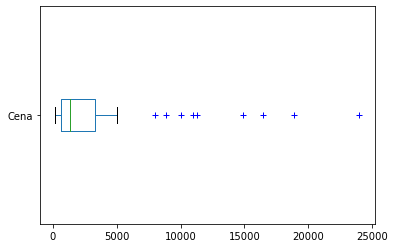

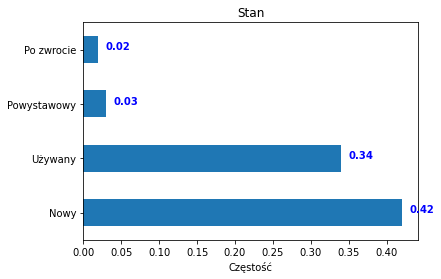

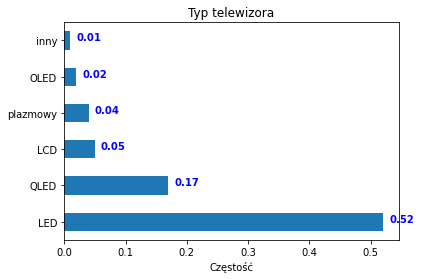

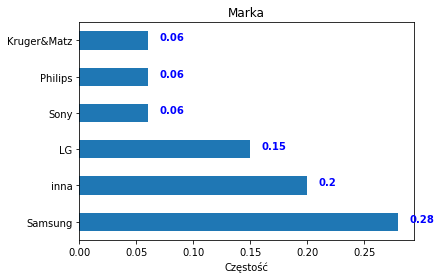

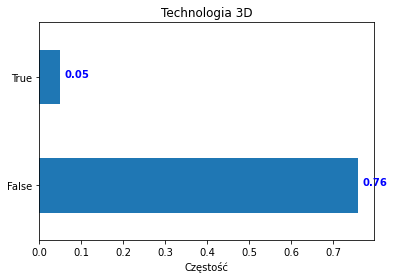

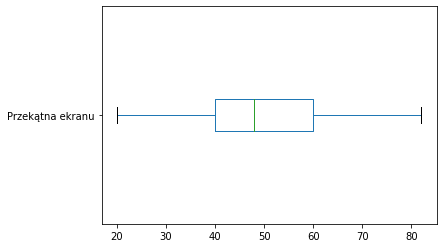

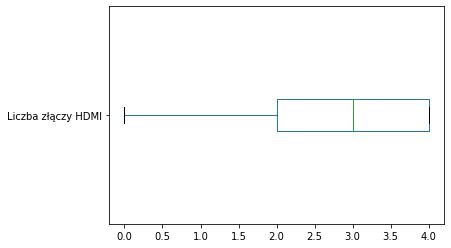

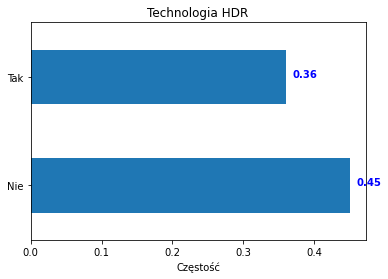

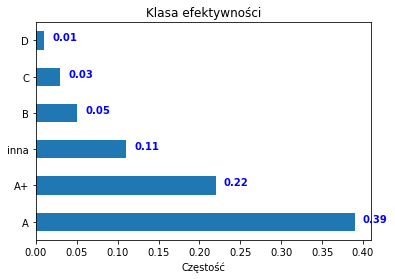

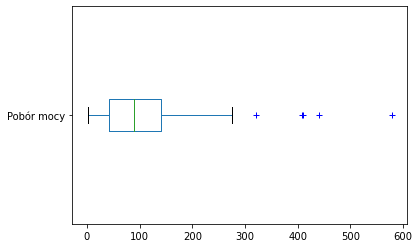

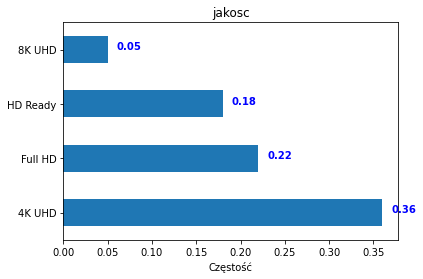

In [6]:
#stystki opisowe
for column in df:
    try:
        ax = df[column].plot(kind = "box" ,vert = False , sym = "b+" )
        #print(df[column].describe())
        plt.savefig(f"figs/{column}.jpg")
        plt.show()
    except:
        TypeError
        ax = df[column].value_counts().div(100).plot(kind = "barh",title= column )
        #print(df[column].value_counts().div(100))
        ax.set_xlabel("Częstość")
        for i, v in enumerate(df[column].value_counts().div(100)):
             ax.text(v + 0.01, i , str(v), color='blue', fontweight='bold')
        plt.savefig(f"figs/{column}.jpg")
        plt.show()

In [7]:
#przygotwanie danych do regresji 
#usuniecie obserwacji odstajacych 
count = df["Cena"]
kwartyl = count.quantile(0.85)
drogie  = count > kwartyl
df = df.drop(drogie.loc[drogie].index)
#df = df.drop("Liczba złączy HDMI" , axis= 1)

regresion_data = pd.get_dummies(df, drop_first=True)
#usunac brakujace dane 
regresion_data = regresion_data.drop("jakosc_8K UHD", axis=1)

<h3>Macierz korelacji 

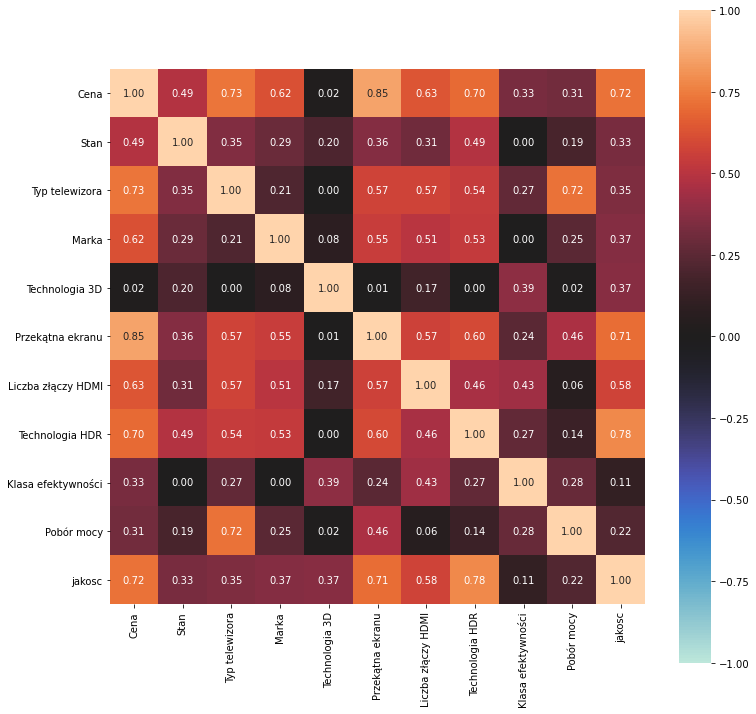

In [8]:
%matplotlib inline
corr_matix  = associations(df,nan_strategy= "drop_features",plot = False, figsize=(12,12))
ax = corr_matix["ax"]

plt.savefig("figs/macierzkorelacji.jpg")

<h3>Model liniowy

In [9]:
Y = regresion_data["Cena"]
X = regresion_data.iloc[:,1:]

X = sm.add_constant(X).astype(float)

model = sm.OLS(Y,X)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Cena   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     17.91
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           1.37e-15
Time:                        00:36:52   Log-Likelihood:                -498.25
No. Observations:                  69   AIC:                             1047.
Df Residuals:                      44   BIC:                             1102.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -793.2401    502.552     -1.578      0.122   -1806.068     219.588
Przekątna ekranu           46.2102      8.122      5.690      0.000      29.842      62.579
Liczba złączy HDMI         -2.8332     88.866     -0.032      0.975    -181.932     176.265
Pobór mocy                  0.4069      1.287      0.316      0.753      -2.187       3.001
Stan_Po zwrocie          -379.1746    348.611     -1.088      0.283   -1081.755     323.406
Stan_Powystawowy          391.6052    327.285      1.197      0.238    -267.995    1051.205
Stan_Używany             -337.6844    190.170     -1.776      0.083    -720.946      45.577
Typ telewizora_LED        -41.0985    246.994     -0.166      0.869    -538.882     456.686
Typ telewizora_OLED      -256.0298    581.007     -0.441      0.662   -1426.973     914.913
Typ telewizora_QLED       908.7689    365.592      2.486      0.017     171.966    1645.572
Typ telewizora_inny       391.9251    509.150      0.770      0.446    -634.199    1418.049
Typ telewizora_plazmowy  -457.9512    437.322     -1.047      0.301   -1339.317     423.414
Marka_LG                  442.5958    282.264      1.568      0.124    -126.271    1011.462
Marka_Philips              99.4449    356.995      0.279      0.782    -620.030     818.920
Marka_Samsung             333.8736    296.659      1.125      0.267    -264.002     931.750
Marka_Sony                292.2040    321.864      0.908      0.369    -356.471     940.879
Marka_inna                 86.5933    228.325      0.379      0.706    -373.566     546.753
Technologia 3D_True       123.1922    296.478      0.416      0.680    -474.320     720.705
Technologia HDR_Tak        62.7285    252.602      0.248      0.805    -446.357     571.814
Klasa efektywności_A+      27.3171    134.129      0.204      0.840    -243.002     297.636
Klasa efektywności_B     -263.0567    491.918     -0.535      0.596   -1254.451     728.338
Klasa efektywności_C      782.4736    587.331      1.332      0.190    -401.214    1966.161
Klasa efektywności_D    -1.208e-12   6.09e-12     -0.198      0.844   -1.35e-11    1.11e-11
Klasa efektywności_inna  -190.0021    210.011     -0.905      0.371    -613.251     233.246
jakosc_Full HD           -120.3698    227.939     -0.528      0.600    -579.750     339.010
jakosc_HD Ready          -110.9307    263.460     -0.421      0.676    -641.900     420.038
==============================================================================
Omnibus:                        2.845   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.030
Skew:                           0.329   Prob(JB):                        0.362
Kurtosis:                       3.523   Cond. No.                     1.23e+16
====================

<h3> Wstepna analiza modelu 

In [10]:
def save_to_latex(content, name):
    try:
        latex = content.as_latex()
    except:
        print("assuming content is alredy in latex")
        latex = content
    with open(f"latex/{name}.tex", "w") as f: 
        f.write(latex)
save_to_latex(result.summary(),"first_model")

<Figure size 720x720 with 0 Axes>

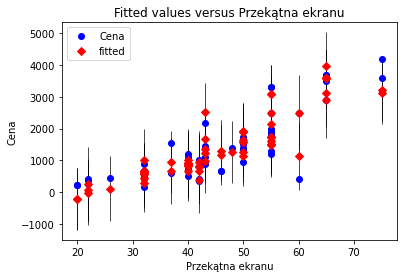

In [11]:
%matplotlib inline
plt.figure( figsize = (10,10))
plot = sm.graphics.plot_fit(result,1)
plt.savefig("figs/wtepna_analiza.jpg")

<h3> Poprawki do modelu</h3>

*  Zbadnie wspoliniowosci 
*  Usuniecie zmiennych nie znaczacych stystycznie metoda wsteczna krokową 

In [12]:
def variance_inflation_factor(exog, exog_idx):
    """variance inflation factor, VIF, for one exogenous variable
    https://en.wikipedia.org/wiki/Variance_inflation_factor
    """
    k_vars = exog.shape[1]
    x_i = exog.iloc[:, exog_idx]
    mask = np.arange(k_vars) != exog_idx
    x_noti = exog.iloc[:, mask]
    r_squared_i = sm.OLS(x_i, x_noti).fit().rsquared
    vif = 1. / (1. - r_squared_i)
    return vif

In [13]:
#wspoliniowsc 
vif_list = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X,i)
    vif_list.append((X.iloc[:,i].name,vif))
vif_list = pd.DataFrame(vif_list)
save_to_latex(vif_list.to_latex(),"VIF")
#nie ma wyskoiej wpołsliniowsci w zmiennych
#wartosc 100 dal const wynika z powodu skalowania.
#https://stats.stackexchange.com/questions/332428/regression-model-constant-causes-multicollinearity-warning-but-not-in-standardi/332597#332597

assuming content is alredy in latex


In [14]:
stan_f = "(Stan_Używany = Stan_Powystawowy = Stan_Po zwrocie )"
typ_f = "(Typ telewizora_LED = Typ telewizora_OLED = Typ telewizora_QLED = Typ telewizora_inny = Typ telewizora_plazmowy = 0)"
marka_f = "(Marka_LG=Marka_Philips=Marka_Samsung= Marka_Sony=Marka_inna =0)"
klasa_f = "(Klasa efektywności_A+ =Klasa efektywności_B = Klasa efektywności_C = Klasa efektywności_D=Klasa efektywności_inna=0)"
jakosc_f = "(jakosc_Full HD= jakosc_HD Ready = 0)"
hdr_f = "(Technologia HDR_Tak = 0)"
tech3D_f = "(Technologia 3D_True=0)"

testy_f = [stan_f,typ_f,marka_f,klasa_f,jakosc_f,hdr_f,tech3D_f]
zmienne_ciagle = ["Pobór mocy","Przekątna ekranu","Liczba złączy HDMI","const"]

def run_test(zmienne_kategoryczne,zmienne_ciagle , model):
    wynik_test = []
    #F test dla dummy zmiennej kategorycznej 
    for test in zmienne_kategoryczne:
        try:
            wynik = model.f_test(test)
            name = test[1:].split(sep = "_")[0]
            s = f"{name} nie jest znacząca"
            s1 = f"{name} jest znaczące"
            wynik_test.append((name, wynik.pvalue))
            #print(f"{s1 if wynik.pvalue < 0.05 else s}")
        except:pass
    #t test dla zmiennych ciaglych 
    for ttest in zmienne_ciagle:
        try:
            wynik_test.append((ttest,model.pvalues[ttest]))
        except:pass
    return wynik_test
        
wynik_test = run_test(testy_f,zmienne_ciagle,result)
wynik_pd = pd.DataFrame(wynik_test)
print(wynik_pd)
save_to_latex(wynik_pd.to_latex(),"Testy_istotnosci")

                     0                     1
0                 Stan   0.13544747232794202
1       Typ telewizora  0.008491797331009644
2                Marka   0.40890046107407024
3   Klasa efektywności    0.5532931630889933
4               jakosc    0.8667612754589771
5      Technologia HDR    0.8050348162403695
6       Technologia 3D    0.6797816760227706
7           Pobór mocy              0.753333
8     Przekątna ekranu            9.6261e-07
9   Liczba złączy HDMI              0.974711
10               const              0.121632
assuming content is alredy in latex


In [15]:
#metoda przyjmuje df oraz liste tupli (nazwa,p-value)
def metoda_wsteczna_krokowa(df, pvalue_list):
    najwieksza = max(pvalue_list, key=itemgetter(1))
    #usuwanie 
    df = df.drop(najwieksza[0], axis= 1)
    return df 

In [16]:
#safeguard from globals 
df2 = df

In [17]:
#while na metode wsteczna krokowa 
while True:
    najwieksza =  max(wynik_test, key=itemgetter(1))
    #gdy wszystkie zmeinne sa stsystcznie znaczace koniec metody krokowej
    if najwieksza[1] < 0.1: break
    print(f"usuwana zmienna to {najwieksza[0]}, z pvalue rowne {najwieksza[1]}")
    df2 = metoda_wsteczna_krokowa(df2,wynik_test)
    regresion_data2 = pd.get_dummies(df2, drop_first=True)
    Y = regresion_data2["Cena"]
    X = regresion_data2.iloc[:,1:]
    X = sm.add_constant(X).astype(float)
    result2 = sm.OLS(Y,X).fit()
    wynik_test = run_test(testy_f,zmienne_ciagle,result2)   
result2.summary()
save_to_latex(result2.summary(),"model_poprawiony")
#wszystkie zmienne sa znaczace 

usuwana zmienna to Liczba złączy HDMI, z pvalue rowne 0.974711137133669
usuwana zmienna to jakosc, z pvalue rowne 0.8627778996805936
usuwana zmienna to Technologia 3D, z pvalue rowne 0.792828352613247
usuwana zmienna to Pobór mocy, z pvalue rowne 0.7259775248299482
usuwana zmienna to Technologia HDR, z pvalue rowne 0.5133421065955824
usuwana zmienna to Marka, z pvalue rowne 0.20835637190097164
usuwana zmienna to Klasa efektywności, z pvalue rowne 0.16149461615509111


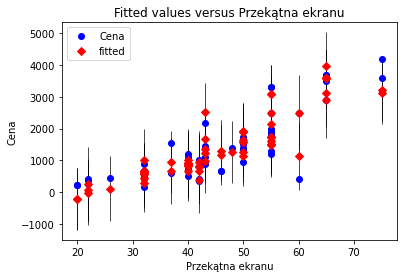

In [18]:
plot = sm.graphics.plot_fit(result,1)
plt.savefig("figs/poprawion_model.jpg")

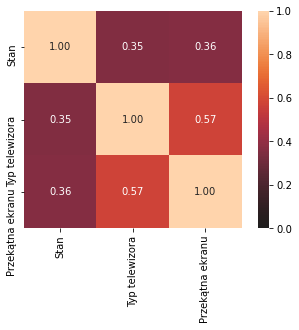

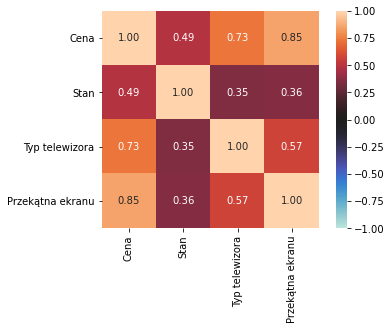

efekt kataliz w parach (i,j) []


In [19]:
def sign(x):
    return math.copysign(1, x)
#macierz korelacji zmeinnych egzodoniczych
R_corr = associations(df2.iloc[:,1:],nan_strategy= "drop_features")
R_corr = np.array(R_corr["corr"])

R = associations(df2,nan_strategy= "drop_features")
R = np.array(R["corr"].iloc[:,0])[1:]

R_sorted = R.argsort()
r_0 = R[R_sorted]
r = R_corr[R_sorted]

pairs = []
for i in range(r.shape[0]):
    for j in range(r.shape[0]):
        if abs(r_0[i]) < abs(r_0[j]):
            r_ij = r[i, j] * sign(r_0[i]) * sign(r_0[j])
            if r_ij > (abs(r_0[i]) / abs(r_0[j])) or r_ij < 0:
                pairs.append((i, j))

if pairs == None: print("Brak efektu katalizy ")
else: print(f"efekt kataliz w parach (i,j) {pairs}")
#brak katalizatorów 

In [20]:
#Normalność rozkładu składnika losowego.
Jarque_Bera_pv = float(result2.summary().tables[2].data[2][3])
if Jarque_Bera_pv >0.1: print("rozklad reszt nie jest normalny ")
else:print("rozklad reszt jest normalny")

rozklad reszt jest normalny


In [21]:
def sort_by(data, sorter):
      sotred_sorter ,sorted_arr = zip( *sorted(zip(sorter,data)))
      return np.array(sorted_arr)
def p_value_test_seri(reszty, Y):
    reszty = np.array(reszty.resid)
    sortedd = sort_by(reszty,Y)
    normalize = np.vectorize(lambda a: 1 if a>0 else 0)
    sortedd = normalize(sortedd)
    series_pvalue = sm.stats.Runs(sortedd).runs_test()
    return series_pvalue[1]

In [22]:
#testing sort by
a = np.array([1,2,3,4,10,7])
b = np.array([100,9,8,6,10,1])
a = sort_by(a,b)
a

array([ 7,  4,  3,  2, 10,  1])

In [23]:
#test seri (Wald)
p_value_test_seri(result2,Y)
#model nie jest liniowy 

0.8216985501200023

In [24]:
p_value_RESET = sm.stats.linear_reset(result2)
p_value_RESET
#Brak podstaw do odrzucenia h_0 pierwotna postac modelu jest poprawna 

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[27.71026936]], p-value=9.611506453997187e-07, df_denom=2>

In [26]:
#test seri dla rouboust result2 brak zmian
p_value_test_seri(result_roboust ,Y)

0.8216985501200023

In [27]:
#transformcaja ceny do log 
Y = np.log(regresion_data2["Cena"])
X = regresion_data2.iloc[:,1:]
X = sm.add_constant(X).astype(float)
result2_log = sm.OLS(Y,X).fit()
result2_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Cena   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     30.81
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           4.06e-19
Time:                        00:36:54   Log-Likelihood:                -22.273
No. Observations:                  69   AIC:                             64.55
Df Residuals:                      59   BIC:                             86.89
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       4.5693      0.231     19.775      0.000       4.107       5.032
Przekątna ekranu            0.0427      0.004     10.132      0.000       0.034       0.051
Stan_Po zwrocie             0.0405      0.269      0.150      0.881      -0.498       0.579
Stan_Powystawowy            0.0863      0.274      0.315      0.754      -0.462       0.635
Stan_Używany               -0.1141      0.103     -1.110      0.272      -0.320       0.092
Typ telewizora_LED          0.4988      0.184      2.705      0.009       0.130       0.868
Typ telewizora_OLED         0.5401      0.488      1.107      0.273      -0.436       1.516
Typ telewizora_QLED         0.9832      0.249      3.956      0.000       0.486       1.481
Typ telewizora_inny         0.1265      0.398      0.318      0.752      -0.670       0.923
Typ telewizora_plazmowy     0.2606      0.255      1.022      0.311      -0.250       0.771
==============================================================================
Omnibus:                       31.663   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.469
Skew:                          -1.394   Prob(JB):                     1.67e-19
Kurtosis:                       7.723   Cond. No.                         591.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
p_value_test_seri(result2_log ,Y)
#transformacja modelu jest poprawna 

0.0010945248619090076

In [29]:
#po korecji na log model liniowy nie jest juz najlepszy 
p_value_RESET = sm.stats.linear_reset(result2_log,2)
p_value_RESET

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.1804874]], p-value=0.6709547118839503, df_denom=1>

In [30]:
#model z przekatna do kwadratu 
Y = np.log(regresion_data2["Cena"])
X = regresion_data2.iloc[:,1:]
X["Przekątna ekranu"] = X["Przekątna ekranu"]**2
X = sm.add_constant(X).astype(float)
result2_log_sq = sm.OLS(Y,X).fit()
print(result2_log_sq.summary())


p_value_test_seri(result2_log_sq ,Y)
#transformacja modelu jest poprawna 

#tearz postac modelu jest juz poprawna 
p_value_RESET = sm.stats.linear_reset(result2_log_sq,2)
p_value_RESET

#breuschpagan test 
breush = sm.stats.diagnostic.het_breuschpagan(result2_log_sq.resid, X)
#p-value of lagrange multiplier test
lm_pvalue = breush[1]
#p-value for the f-statistic
f_pvalue = breush[3]
print(f" Brauch{lm_pvalue,f_pvalue}")
#h_0 =homoskedasticity , odrzucam wiec jest heterodastycznosc
#white test 
white = sm.stats.diagnostic.het_white(result2_log_sq.resid,X)
lm_pvalue = white[1]
#p-value for the f-statistic
f_pvalue = white[3]
print(f" White {lm_pvalue,f_pvalue}")
#h_0 =homoskedasticity , odrzucam wiec jest heterodastycznosc
#wystepuje niska heterodastycznosc 

                            OLS Regression Results                            
Dep. Variable:                   Cena   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     27.08
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           8.33e-18
Time:                        00:36:54   Log-Likelihood:                -25.902
No. Observations:                  69   AIC:                             71.80
Df Residuals:                      59   BIC:                             94.14
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

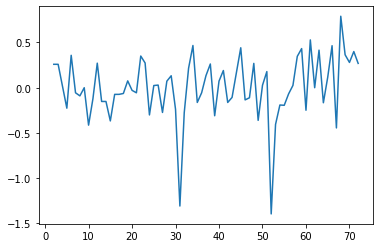

In [31]:
result2_log_sq.resid.plot()
#wynika to z pojedynczych obserwacji 

In [32]:
outliers = result2_log_sq.resid < -1
#X.loc[outliers]
to_drop = X.loc[outliers].index
X = X.drop(to_drop)
Y = Y.drop(to_drop)

In [33]:
result2_log_sq = sm.OLS(Y,X).fit()

breush = sm.stats.diagnostic.het_breuschpagan(result2_log_sq.resid, X)
#p-value of lagrange multiplier test
lm_pvalue = breush[1]
#p-value for the f-statistic
f_pvalue = breush[3]
print(f" Brauch{lm_pvalue,f_pvalue}")
#h_0 =homoskedasticity , odrzucam wiec jest heterodastycznosc


#white test 
white = sm.stats.diagnostic.het_white(result2_log_sq.resid,X)
lm_pvalue = white[1]
#p-value for the f-statistic
f_pvalue = white[3]
print(f" White {lm_pvalue,f_pvalue}")

 Brauch(0.5238508718205751, 0.5558075302526411)
 White (0.8034022194763257, 0.8550166828771517)


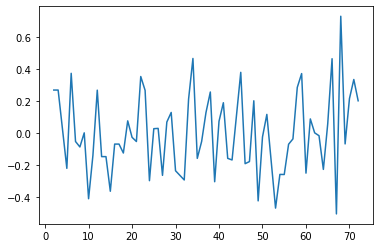

In [34]:
result2_log_sq.resid.plot()

In [35]:
X2 = X
X2["Przekątna ekranu"] = X["Przekątna ekranu"] / np.sqrt(np.exp(result2_log_sq.resid)**2)
Y2 = np.log(np.exp(Y)/ np.sqrt(np.exp(result2_log_sq.resid)**2))


In [36]:
result2_log_sq_het = sm.OLS(Y2,X2).fit()
result2_log_sq_het.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     83.98
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           1.39e-29
Time:                        00:36:54   Log-Likelihood:                 15.819
No. Observations:                  67   AIC:                            -11.64
Df Residuals:                      57   BIC:                             10.41
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       5.4734      0.112     48.789      0.000       5.249       5.698
Przekątna ekranu            0.0003   2.04e-05     15.243      0.000       0.000       0.000
Stan_Po zwrocie             0.2437      0.153      1.592      0.117      -0.063       0.550
Stan_Powystawowy            0.2530      0.156      1.621      0.111      -0.060       0.566
Stan_Używany               -0.0085      0.060     -0.142      0.887      -0.128       0.111
Typ telewizora_LED          0.7772      0.104      7.454      0.000       0.568       0.986
Typ telewizora_OLED         0.9324      0.278      3.355      0.001       0.376       1.489
Typ telewizora_QLED         1.3962      0.138     10.145      0.000       1.121       1.672
Typ telewizora_inny        -0.0939      0.227     -0.413      0.681      -0.549       0.361
Typ telewizora_plazmowy     1.0073      0.153      6.579      0.000       0.701       1.314
==============================================================================
Omnibus:                        2.241   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.326   Jarque-Bera (JB):                1.548
Skew:                           0.140   Prob(JB):                        0.461
Kurtosis:                       2.310   Cond. No.                     3.34e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
breush = sm.stats.diagnostic.het_breuschpagan(result2_log_sq_het.resid, X)
#p-value of lagrange multiplier test
lm_pvalue = breush[1]
#p-value for the f-statistic
f_pvalue = breush[3]
print(f" Brauch{lm_pvalue,f_pvalue}")
#h_0 =homoskedasticity , odrzucam wiec jest heterodastycznosc


#white test 
white = sm.stats.diagnostic.het_white(result2_log_sq_het.resid,X)
lm_pvalue = white[1]
#p-value for the f-statistic
f_pvalue = white[3]
print(f" White {lm_pvalue,f_pvalue}")



 Brauch(0.00121496087656298, 0.0002279771486529164)
 White (0.006130595677375958, 0.000834625015490135)


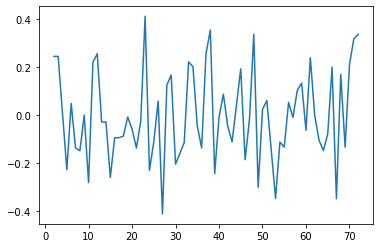

In [38]:
result2_log_sq_het.resid.plot()

In [39]:
#model jest liniowy
p_value_test_seri(result2_log_sq_het,Y)

7.87339312966854e-05

In [40]:
#postac modelu jest prawidlowa
p_value_RESET = sm.stats.linear_reset(result2_log_sq_het,3)
p_value_RESET

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[10.23619087]], p-value=0.005987415476687934, df_denom=2>

In [41]:
Xd = np.array(X)
len(Xd)

67

In [42]:
#test Chowa
from sklearn.model_selection import train_test_split
def chow_test(X , Y):
    n= X.shape[0]
    k = X.shape[1]
    x_1, x_2 , y_1, y_2 =  train_test_split(X,Y,test_size=0.5)
    
    ols_1 = sm.OLS( y_1,x_1)
    ols_2 = sm.OLS( y_2,x_2)
    mod_1 = ols_1.fit()
    mod_2 = ols_2.fit()
    rsk_1 = mod_1.ssr
    rsk_2 = mod_2.ssr
    rsk = sm.OLS(Y, X).fit()
    rsk = rsk.ssr
    r_1 = k - 1
    r_2 = n - 2 * (k -1)
    f_stat = ((rsk - rsk_1 - rsk_2) / (rsk_1 + rsk_2)) * (r_2 / r_1)
    #return p-value of F statistic
    return stats.f.sf(f_stat, dfn=r_1, dfd=r_2)

In [43]:
chow_list = []
for i in range(20):
    chow_list.append(chow_test(X2,Y2))
chow_list
#test chowa pokazuje ze model nie jest stabilny, ponieważ jest mło danych i duża wariancja w dancyh.

[0.07203651764096047,
 0.06103252881001483,
 0.10045407755791087,
 0.137045902233291,
 0.8596327799300048,
 0.8576352162617102,
 0.9601697140868227,
 0.8254273968382212,
 0.8843503971925041,
 0.8595972541032955,
 0.5009437016587982,
 0.10301930573030114,
 0.8466289661303636,
 0.08481907267399173,
 0.17327356823637471,
 0.3506896106725174,
 0.29467045894125143,
 0.02765547224232798,
 0.12701633779046947,
 0.9972688692317342]

In [44]:
#wspołliniowosc 
vif_list = []
for i in range(X2.shape[1]):
    vif = variance_inflation_factor(X2,i)
    vif_list.append((X2.iloc[:,i].name,vif))
vif_list 
#poza const nie ma wysokiej wpołliniowosci 

[('const', 19.646679896070882),
 ('Przekątna ekranu', 1.4069857921340494),
 ('Stan_Po zwrocie', 1.0596799030449333),
 ('Stan_Powystawowy', 1.6276167681036937),
 ('Stan_Używany', 1.3756283599778791),
 ('Typ telewizora_LED', 3.4482784487409726),
 ('Typ telewizora_OLED', 1.772559695364782),
 ('Typ telewizora_QLED', 3.4386523381147827),
 ('Typ telewizora_inny', 1.1866668394770121),
 ('Typ telewizora_plazmowy', 1.5652188031159513)]

In [45]:
def collinearity_test(X):
        collinear = []
        for i in range(X.shape[1]):
            x = X.drop(X.columns[i], axis=1)
            model = sm.OLS(X.iloc[:,i],x)
            res = model.fit()
            if res.rsquared  > 0.9:
                collinear.append(X.columns[i])
        return collinear

In [46]:
coliniar = collinearity_test(X2)
coliniar
#wysoka wspolniwososc const wynika ze złego scalowania

['const']

In [63]:
#koincydencja 
def model_coincidence(X_w,Y):
    X = np.array(X_w)
    Y = np.array(Y)
    r_0 = [np.corrcoef(X[:, i], Y)[0][1] for i in range(X.shape[1])]
    x_t_x_inverse = np.linalg.inv(X.T @ X)
    a = x_t_x_inverse @(X.T@Y)
    results = []
    for r in range(X.shape[1]):
        if sign(r_0[r]) != sign(a[r]):
            results.append(
                dict(variable=X_w.columns[r], a=a[r], r=r_0[r])
            )
    return results

'Przekątna ekranu'

In [64]:
koincydencja = model_coincidence(X2,Y2)
kincydencja
#koincydecja w dummy varieble nie jest znaczaca, 

[{'variable': 'const', 'a': 5.473398436293408, 'r': nan},
 {'variable': 'Typ telewizora_LED',
  'a': 0.7772159201836502,
  'r': -0.19060863974108333}]

In [68]:
X2.loc[X2["Typ telewizora_LED"] == 1]
# wynika to z tego ze dyspropocji w dummy variebles 

AttributeError: 'DataFrame' object has no attribute 'value_counts'

<h3> Wybór modelu </h3>
Wszyskie tessty zakonczone. 
Otrzymany model ma postać: 
log(Cena) = a + a_1 * przekątna_ekranu^2 + a_3 *stan + a_4 * typ
Teraz zbiórczo testy dla tego modelu 
oraz przwidywania z 95% 
poziom istotnosci modelu to apha = 0.1 


<h3>Testowanie Modelu oraz Pełny opis</h3>

*  Współczynnik determinacji.
*  Efekt katalizy.
*  Normalność rozkładu składnika losowego.
*  Istotność zmiennych.
*  Testy dodanych (pominiętych zmiennych).
*  Obserwacje odstające.
*  Test liczby serii (uporządkować obserwacje!!).
*  Test RESET.19.Testowanie heteroskeastyczności.
*  Test Chowa (wraz z komentarzem na temat podziału próbki na dwie grupy).
*  Współliniowość.
*  Koincydencja.
*  Interpretacja parametrów modelu (tam gdzie trzeba elastyczność).
*  predykcja wraz z 95% przedziałem ufności.

In [ ]:
#wczytanie danych i stworzenie dummy variable
Dane = df2.gget_dummies(df2, drop_first=True)
#Czyste przypisanie zmeinyych endo i egzo
Y = Dane["Cena"]
X = Dane.iloc[:,1:]
X = sm.add_constant(X).astype(float)



#tranformacja danych 
Y = np.log(Y)
X["Przekątna ekranu"] = X["Przekątna ekranu"]**2
#początkowy fit
final_model = sm.OLS(Y,X).fit()

#usuniecie odstajacych obserwacji
outliers = final_model.resid < -1
to_drop = X.loc[outliers].index
X = X.drop(to_drop)
Y = Y.drop(to_drop)

#korekcja heterodastyczności 
X["Przekątna ekranu"] = X["Przekątna ekranu"] / np.sqrt(np.exp(final_model.resid)**2)
Y = np.log(np.exp(Y)/ np.sqrt(np.exp(final_model.resid)**2))

print(final_model.summary())
#Współczynik Determinacji 
print(f"F-vaule dla modelu wynosi{final_model.fvalue} \n Brak podstaw do orzucenia H_0\n R^2 jest statystycznie znaczące")

#Badanie efektu katalizy
R_corr = associations(df2.iloc[:,1:],nan_strategy= "drop_features")
R_corr = np.array(R_corr["corr"])

R = associations(df2,nan_strategy= "drop_features")
R = np.array(R["corr"].iloc[:,0])[1:]

R_sorted = R.argsort()
r_0 = R[R_sorted]
r = R_corr[R_sorted]

pairs = []
for i in range(r.shape[0]):
    for j in range(r.shape[0]):
        if abs(r_0[i]) < abs(r_0[j]):
            r_ij = r[i, j] * sign(r_0[i]) * sign(r_0[j])
            if r_ij > (abs(r_0[i]) / abs(r_0[j])) or r_ij < 0:
                pairs.append((i, j))
print(f"efekt kataliz występuje w parach (i,j) {pairs}")

#Normalność reszt 
Jarque_Bera_pv = float(final_model.summary().tables[2].data[2][3])
print(f"P-value dla Jarque_Bera wynosi {Jarque_Bera_pv}")
#test istotnosci zmiennych oraz testy danych usuniętych
stan_f = "(Stan_Używany = Stan_Powystawowy = Stan_Po zwrocie )"
typ_f = "(Typ telewizora_LED = Typ telewizora_OLED = Typ telewizora_QLED = Typ telewizora_inny = Typ telewizora_plazmowy )"
testy_f = [stan_f,typ_f]
zmienne_ciagle = ["Przekątna ekranu","const"]

wynik_test = run_test(testy_f,zmienne_ciagle, final_model)
wynik_pd = pd.DataFrame(wynik_test)
print(wynik_pd)
print("Wszystkie zmienne są statystycznie istotne na podstawie metody wstecznej krokowej")
save_to_latex(wynik_pd.to_latex(),"Testy_istotnosci")

#test seri 
print(p_value_test_seri(final_model ,Y))
print("Brak podstaw do odrzucenia H_0 na poziomie 0.1\n Model jest linowy ")

#test RESET
print(sm.stats.linear_reset(final_model))
print("Brak podstaw do odrzucenia H_0 na poziomie 0.1\n Postać modelu jest poprawna ")

#Testowanie heteroskeastyczności
breush = sm.stats.diagnostic.het_breuschpagan(final_model.resid, X)
lm_pvalue = breush[1]
f_pvalue = breush[3]
print(f" P-value dla Breusch-Pagan ={lm_pvalue}, F-value = {f_pvalue}")
print("Brak podstaw do odrzucenia H_0 na poziomie 0.1\n Model jest homodekatyczny na podstawie testu Breusch-Pagan")

white = sm.stats.diagnostic.het_white(final_model.resid,X)
lm_pvalue = white[1]
#p-value for the f-statistic
f_pvalue = white[3]
print(f" P-value dla Breusch-Pagan ={lm_pvalue}, F-value = {f_pvalue}")
print("Brak podstaw do odrzucenia H_0 na poziomie 0.1\n Model jest homodekatyczny na podstawie testu White'a")

#Test Chowa 
chow_list = []
for i in range(20):
    chow_list.append(chow_test(X2,Y2))
chow_list = pd.DataFrame(chow_list)
print(chow_list)
print("Model nie jest stabliny")
#Współlinowość 
vif_list = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X,i)
    vif_list.append((X.iloc[:,i].name,vif))
vif_list = pd.DataFrame(vif_list)
#save to latex
print(vif_list)
print("Nie wpółlinowości między zmienymi(dla wszytkich zmeinnych vif < 5, ingorujemy const")

coliniar = collinearity_test(X)
coliniar = pd.DataFrame(coliniar)

print(coliniar)
print("Nie ma wyskoiej współliniowiści, ingnorujemy const")

#Koincydencja 
koincydencja = model_coincidence(X2,Y2)
koincydencja = pd.DataFrame(koincydencja)


#Interpretacja Parametrów


#Predykcje z 95% przedziałem ufności 